In [73]:
#importing dependencies

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.metrics import accuracy_score
from math import sin, cos, sqrt, atan2, radians
from statistics import mode, median
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K
from keras import layers, models
from keras.utils import np_utils
from keras.backend import relu, sigmoid
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras import optimizers
from keras import metrics

from sklearn.externals import joblib

from boto.s3.connection import S3Connection, Location
from boto.s3.key import Key

import os


%matplotlib inline

#to suppress warnings
pd.options.mode.chained_assignment = None

In [6]:
#reading the train data set for years 2016 and 2017

train_2016_df = pd.read_csv("../Midterm/train_2016_v2.csv", parse_dates=["transactiondate"])
train_2017_df = pd.read_csv("../Midterm/train_2017.csv", parse_dates=["transactiondate"])


#appending the year column to each data frame

train_2017_df['Year'] = '2017'
train_2016_df['Year'] = '2016'


#appending month column

train_2017_df['month'] = train_2017_df.transactiondate.dt.month
train_2016_df['month'] = train_2016_df.transactiondate.dt.month

#appending 'year-month' column

train_2017_df['year-month'] = train_2017_df.apply(lambda x : str(x['Year']) + '-' + str(x['month']), axis=1)
train_2016_df['year-month'] = train_2016_df.apply(lambda x : str(x['Year']) + '-' + str(x['month']), axis=1)


In [7]:
#finding the average log error

average_log_error_2016 = train_2016_df.groupby(by = 'year-month').mean().reset_index()
average_log_error_2017 = train_2017_df.groupby(by = 'year-month').mean().reset_index()

#sorting by month

average_log_error_2016.sort_values(by = 'month', ascending=True, inplace=True)
average_log_error_2017.sort_values(by = 'month', ascending=True, inplace=True)


In [8]:
#merging the two train files

train_result_df = pd.concat([train_2016_df, train_2017_df], ignore_index=True)

In [9]:
#reading the property files for years 2016 and 2017

prop_2016_df = pd.read_csv("../Midterm/properties_2016.csv", low_memory=False)
prop_2017_df = pd.read_csv("../Midterm/properties_2017.csv", low_memory=False)


#appending the year column to each data frame

prop_2016_df['Year'] = '2016'
prop_2017_df['Year'] = '2017'


#merging the two property files

prop_result_df = pd.concat([prop_2016_df, prop_2017_df], ignore_index=True)

#droping duplicates

prop_result_df.drop_duplicates(inplace=True)

#merging the property files and training files to get a complete data frame
complete_16_df = pd.merge(prop_2016_df, train_2016_df, on='parcelid', how='right')
complete_17_df = pd.merge(prop_2017_df, train_2017_df, on='parcelid', how='right')

complete_df = pd.concat([complete_16_df, complete_17_df], ignore_index=True)

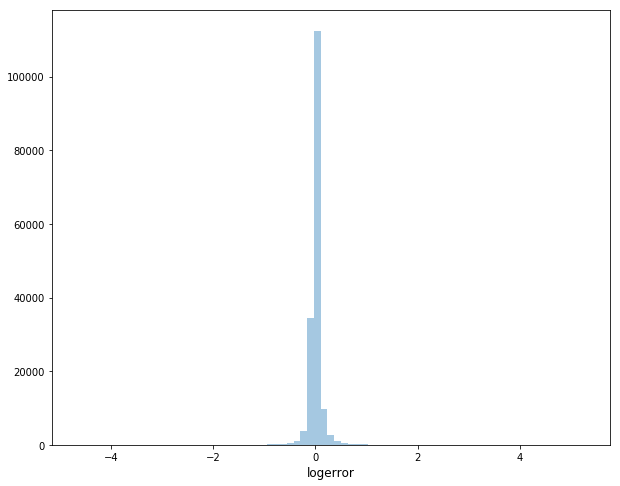

In [71]:
#Exploratory Data Analytics 

#1. Plotting a Histogram of the Logerrors

plt.figure(figsize=(10,8))
sns.distplot(train_result_df.logerror.values, bins=75, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

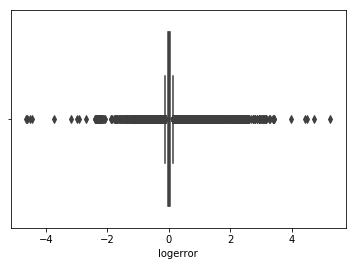

In [11]:
#2. Plotting a box plot to check the outliers in logerrors if any

sns.boxplot(x="logerror", data=complete_df);

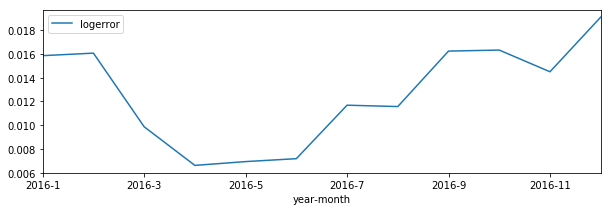

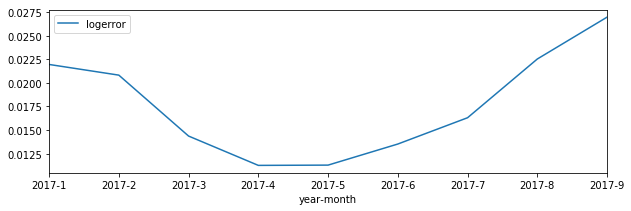

In [12]:
#3. Plotting the average log error

average_log_error_2016.plot(x = 'year-month', y='logerror', figsize=(10,3))
average_log_error_2017.plot(x = 'year-month', y='logerror', figsize=(10,3))

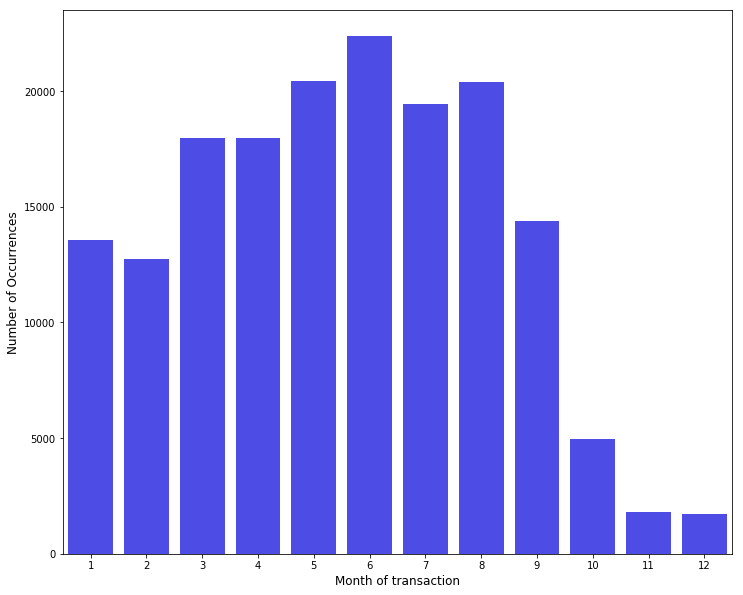

In [13]:

#4. Plotting a bar chart to compare the month wise transaction made in the data set

cnt_srs = train_result_df['month'].value_counts()
plt.figure(figsize=(12,10))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='blue')
plt.xticks(rotation='horizontal')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

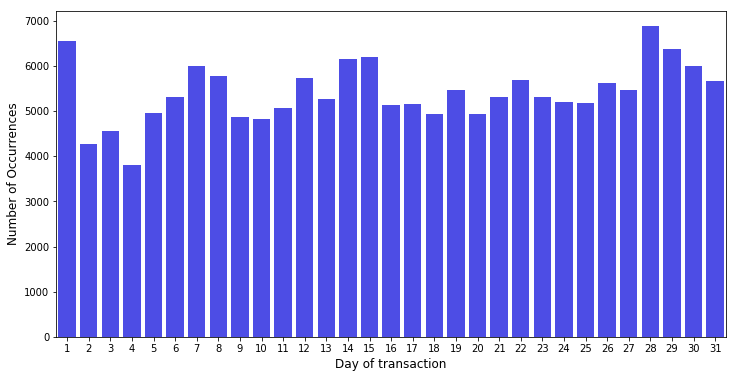

In [14]:

#5. Plotting a bar chart to compare the day wise transaction made in the data set

train_result_df['transaction_day'] = train_result_df['transactiondate'].dt.day

cnt_srs = train_result_df['transaction_day'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='blue')
plt.xticks(rotation='horizontal')
plt.xlabel('Day of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

In [15]:

#6. To check the count of parcel ids occuring more that one times

train_result_df['parcelid'].value_counts().reset_index()['parcelid'].value_counts()

1    162541
2      2660
3         9
Name: parcelid, dtype: int64

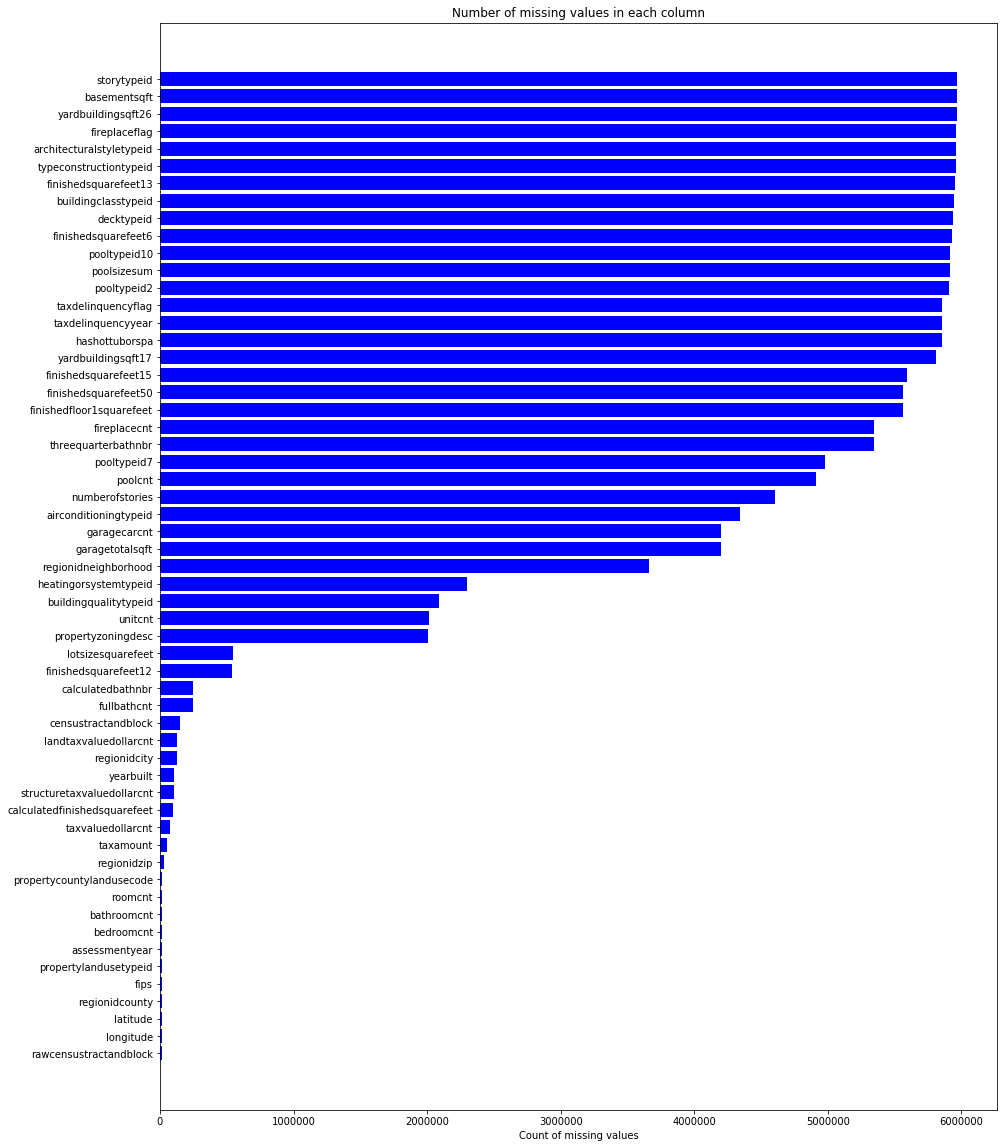

In [16]:

#7. Checking for missing values in the property data sets
missing_df = prop_result_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.8
fig, ax = plt.subplots(figsize=(15,20))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

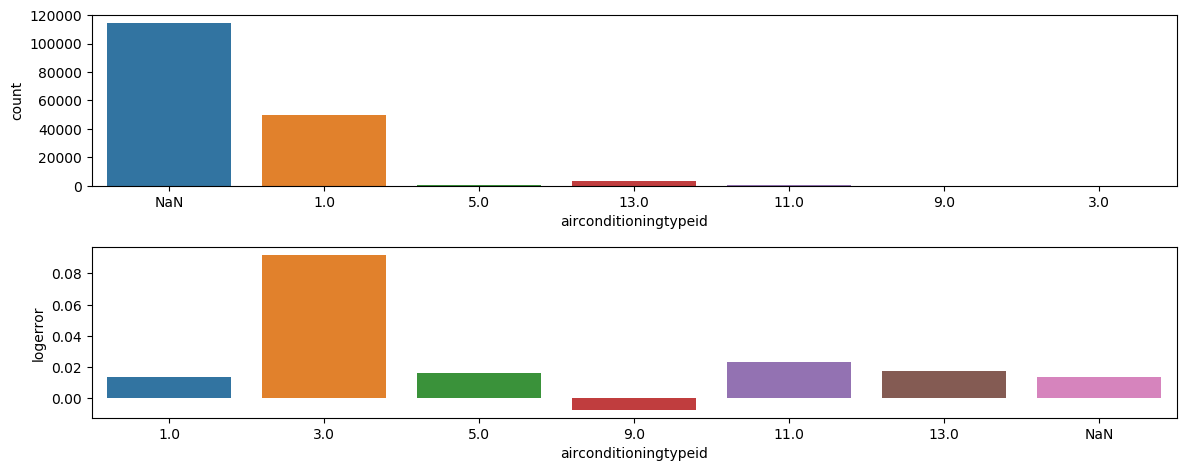

In [17]:

#8. Inspect Categorical Data

#selecting a categorical data and checking out the contribution to the logerror

feature = 'airconditioningtypeid'

fig  = plt.figure(figsize=(12, 9), dpi=100);
axes1 = fig.add_subplot(411);
axes2 = fig.add_subplot(412);

sns.countplot(complete_df[feature].fillna('NaN'), ax=axes1);
bar_df1 = complete_df[[feature, "logerror"]].fillna('NaN').groupby([feature], as_index=False).mean()
sns.barplot(x=feature, y='logerror', data=bar_df1, ax=axes2);
fig.tight_layout()

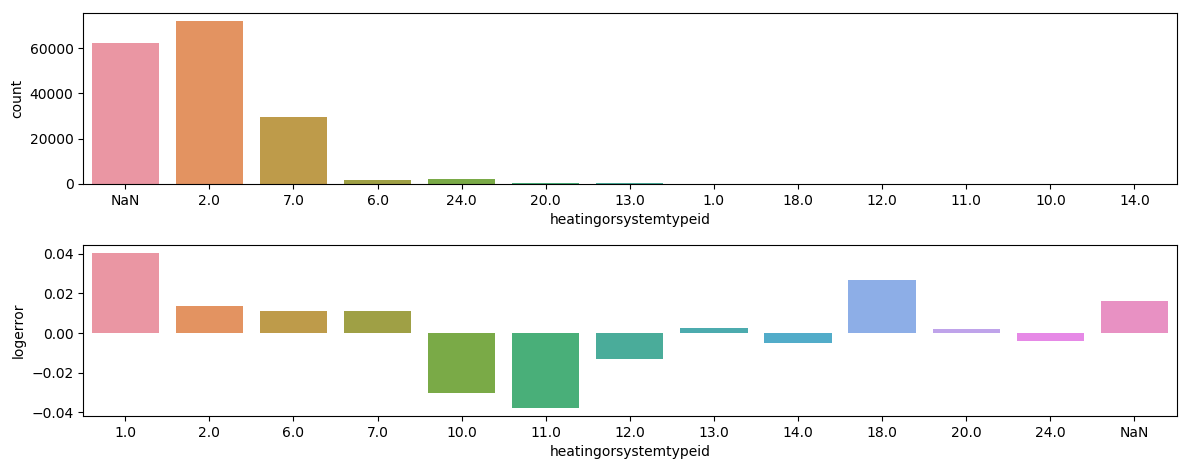

In [18]:

feature = 'heatingorsystemtypeid'

fig  = plt.figure(figsize=(12, 9), dpi=100);
axes1 = fig.add_subplot(411);
axes2 = fig.add_subplot(412);

sns.countplot(complete_df[feature].fillna('NaN'), ax=axes1);
bar_df1 = complete_df[[feature, "logerror"]].fillna('NaN').groupby([feature], as_index=False).mean()
sns.barplot(x=feature, y='logerror', data=bar_df1, ax=axes2);
fig.tight_layout()

In [19]:

# keeping a threshold of 70% and keeping the rest

cleared_column_df = complete_df.dropna(axis=1, thresh=0.30 * complete_df.shape[0])
cleared_row_column_df = cleared_column_df.dropna(axis=0, thresh = 0.30 * (cleared_column_df.shape[1]))


In [20]:

#removing previously added columns

del cleared_row_column_df['year-month']
del cleared_row_column_df['month']
del cleared_row_column_df['Year_y']

cleared_row_column_df.shape

(167854, 36)

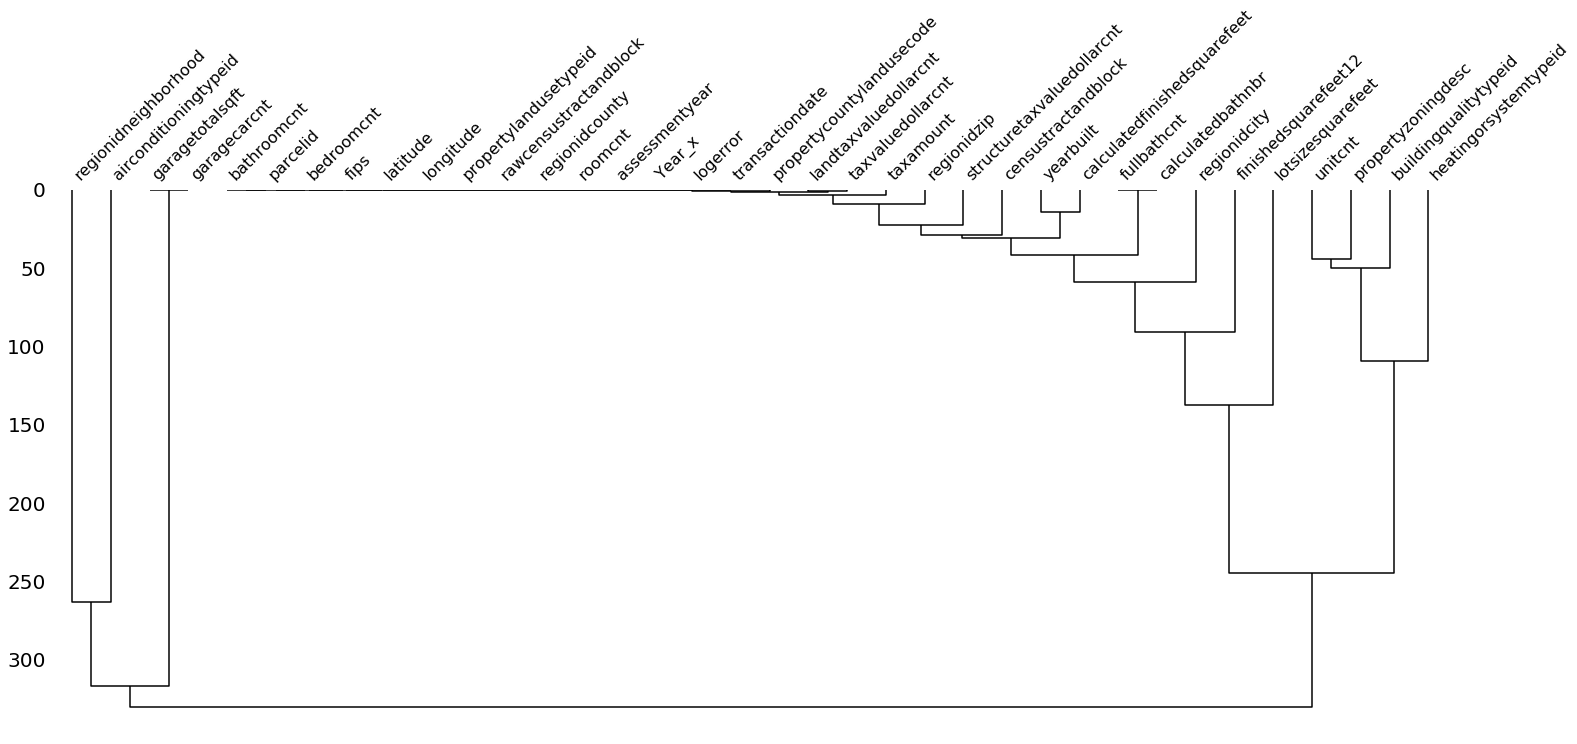

In [21]:

#9. plotting a dendogram to check the correlations of the features in the data set

msno.dendrogram(cleared_row_column_df)

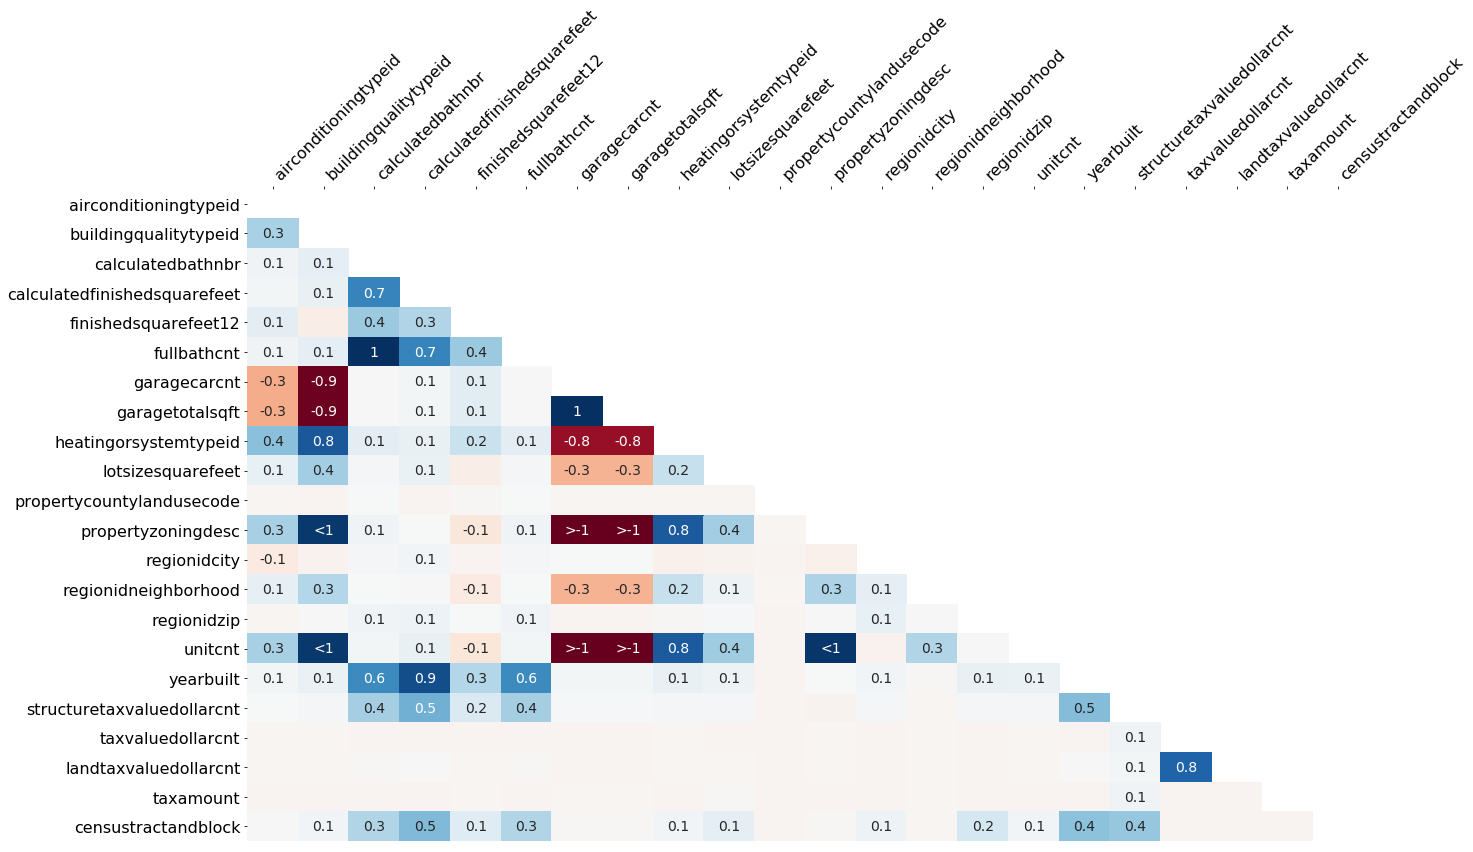

In [22]:

#10. plotting a heatmap to further analyse the correlations within them

msno.heatmap(cleared_row_column_df)

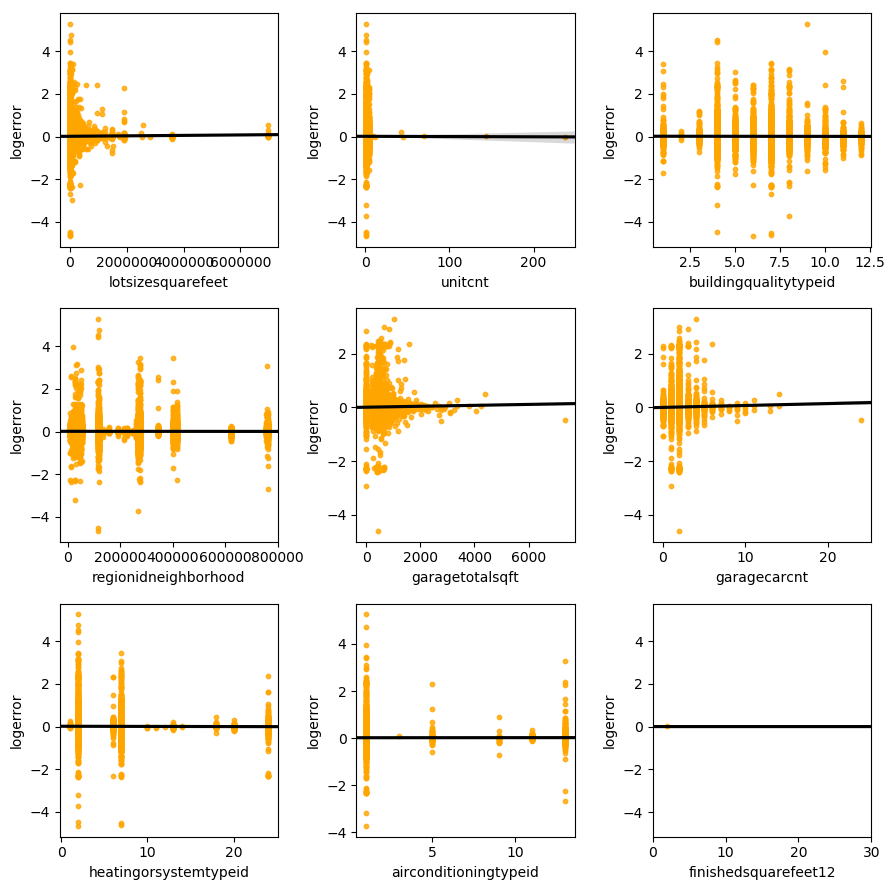

In [23]:

#11. House Characteristics

fig  = plt.figure(figsize=(9, 9), dpi=100);


axes1 = fig.add_subplot(331); 
axes2 = fig.add_subplot(332); 
axes3 = fig.add_subplot(333); 
axes4 = fig.add_subplot(334);
axes5 = fig.add_subplot(335);
axes6 = fig.add_subplot(336); 
axes7 = fig.add_subplot(337);
axes8 = fig.add_subplot(338);
axes9 = fig.add_subplot(339); 

sns.regplot(x='lotsizesquarefeet', y='logerror', data=cleared_row_column_df, ax=axes1, scatter_kws={"s": 10, "color":"orange"}, line_kws={"color":"black"});
sns.regplot(x='unitcnt', y='logerror', data=cleared_row_column_df, ax=axes2, scatter_kws={"s": 10, "color":"orange"}, line_kws={"color":"black"});
sns.regplot(x='buildingqualitytypeid', y='logerror', data=cleared_row_column_df, ax=axes3, scatter_kws={"s": 10, "color":"orange"}, line_kws={"color":"black"});
sns.regplot(x='regionidneighborhood', y='logerror', data=cleared_row_column_df, ax=axes4, scatter_kws={"s": 10, "color":"orange"}, line_kws={"color":"black"});
sns.regplot(x='garagetotalsqft', y='logerror', data=cleared_row_column_df, ax=axes5, scatter_kws={"s": 10, "color":"orange"}, line_kws={"color":"black"});
sns.regplot(x='garagecarcnt', y='logerror', data=cleared_row_column_df, ax=axes6, scatter_kws={"s": 10, "color":"orange"}, line_kws={"color":"black"});
sns.regplot(x='heatingorsystemtypeid', y='logerror', data=cleared_row_column_df, ax=axes7, scatter_kws={"s": 10, "color":"orange"}, line_kws={"color":"black"});
sns.regplot(x='airconditioningtypeid', y='logerror', data=cleared_row_column_df, ax=axes8, scatter_kws={"s": 10, "color":"orange"}, line_kws={"color":"black"});
sns.regplot(x='finishedsquarefeet12', y='logerror', data=cleared_row_column_df, ax=axes9, scatter_kws={"s": 10, "color":"orange"}, line_kws={"color":"black"});

axes9.set_xlim(0, 30)

fig.tight_layout();

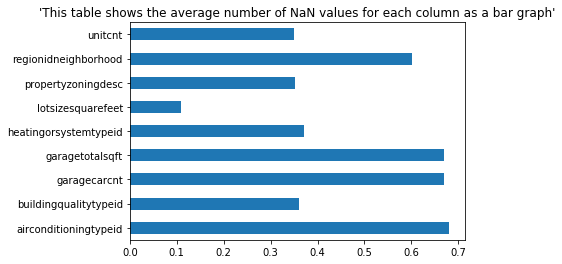

In [24]:

#plotting the null columns after cleaning the thresholds

fig = plt.figure()
nan_dist = cleared_row_column_df.isnull().mean(axis=0)

nan_dist[nan_dist > 0.1].plot.barh()
plt.title("'This table shows the average number of NaN values for each column as a bar graph'")

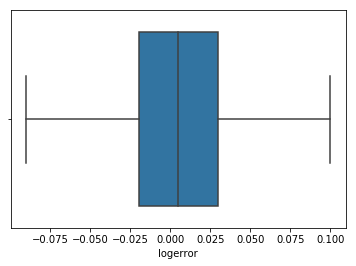

In [25]:

# Data Cleansing

#1. Removing the outliers of log errors

abc = cleared_row_column_df[cleared_row_column_df['logerror'] < .1]
abc = abc[abc['logerror'] > -.09]
sns.boxplot(abc['logerror'])

cleared_row_column_df = abc

In [26]:

#2. Filling RegionIdNeighbourHood

rn_df = cleared_row_column_df[cleared_row_column_df['regionidneighborhood'].notnull()]

rn_df_X = rn_df[['latitude', 'longitude']]
rn_df_Y = rn_df['regionidneighborhood']

# splitting data
rn_x_train, rn_x_test, rn_y_train, rn_y_test = train_test_split(rn_df_X, rn_df_Y, random_state=0)

# using NearestCentriod 
nc = NearestCentroid()
nc.fit(rn_x_train, rn_y_train)
predictions = nc.predict(rn_x_test)
print(accuracy_score(rn_y_test, predictions))

0.783397511848


In [27]:

# fill the null values in the data frame

null_rn = cleared_row_column_df[cleared_row_column_df['regionidneighborhood'].isnull()]
null_rn['regionidneighborhood'] = nc.predict(null_rn[['latitude', 'longitude']])

cleared_row_column_df = pd.concat([rn_df, null_rn], ignore_index=True)

In [28]:

#3. Filling LotSizeSquareFeet

null_lotsize_df = cleared_row_column_df[cleared_row_column_df['lotsizesquarefeet'].isnull()]
notnull_lotsize_df = cleared_row_column_df[cleared_row_column_df['lotsizesquarefeet'].notnull()]

# using the mean value of the lotsizesquarefeet within a 1 mile radius of the lot
def determine_average_lot_size(row) :
    row_lat = row['latitude'] / 10e6
    row_lon = row['longitude'] / 10e6
    bounding_lon_1 = row_lon - (1 / (abs(cos(row_lat) * 69)))
    bounding_lon_2 = row_lon + (1 / (abs(cos(row_lat) * 69)))
    bounding_lat_1 = row_lat - (1 / 69)
    bounding_lat_2 = row_lat + (1 / 69)
    filtered_df = notnull_lotsize_df[(notnull_lotsize_df['latitude'] / 10e6 > bounding_lat_1) & (notnull_lotsize_df['latitude'] / 10e6 < bounding_lat_2) & (notnull_lotsize_df['longitude'] / 10e6 > bounding_lon_1) & (notnull_lotsize_df['longitude'] / 10e6 < bounding_lon_2)]
    return filtered_df['lotsizesquarefeet'].mean()


# applying the function along input axis of data frame

null_lotsize_df['lotsizesquarefeet'] = null_lotsize_df.apply(determine_average_lot_size, axis = 1)


# fill the null values in the data frame

cleared_row_column_df = pd.concat([notnull_lotsize_df, null_lotsize_df], ignore_index=True)


In [29]:

#4. Filling BuildingQualityTypeId

null_building_q_df = cleared_row_column_df[cleared_row_column_df['buildingqualitytypeid'].isnull()]
notnull_building_q_df = cleared_row_column_df[cleared_row_column_df['buildingqualitytypeid'].notnull()]

# using the median value

null_building_q_df.fillna(value= {'buildingqualitytypeid' : median(notnull_building_q_df['buildingqualitytypeid'])}, inplace=True)


# fill the null values in the data frame

null_building_q_df[null_building_q_df['buildingqualitytypeid'].isnull()]
cleared_row_column_df = pd.concat([null_building_q_df, notnull_building_q_df], ignore_index=True)

In [30]:

#5. Filling HeatingOrSystemTypeId

null_heating = cleared_row_column_df[cleared_row_column_df['heatingorsystemtypeid'].isnull() & cleared_row_column_df['finishedsquarefeet12'].notnull()]
not_null_heating = cleared_row_column_df[cleared_row_column_df['heatingorsystemtypeid'].notnull() & cleared_row_column_df['finishedsquarefeet12'].notnull()]

heating_x1 = not_null_heating[['finishedsquarefeet12', 'buildingqualitytypeid', 'lotsizesquarefeet', 'regionidneighborhood']]
heating_y1 = not_null_heating[['heatingorsystemtypeid']]

# splitting data

heat_x_train, heat_x_test, heat_y_train, heat_y_test = train_test_split(heating_x1, heating_y1, random_state=0)

# Using KNN Classifiers
heat_knn = KNeighborsClassifier(n_neighbors=5)
heat_knn.fit(heat_x_train, heat_y_train.values.ravel())
heat_predictions = heat_knn.predict(heat_x_test)
print(accuracy_score(heat_y_test.values.ravel(), heat_predictions))

0.83265932227


In [31]:

# fill the null values in the data frame

null_heating['heatingorsystemtypeid'] = heat_knn.predict(null_heating[['finishedsquarefeet12', 'buildingqualitytypeid', 'lotsizesquarefeet', 'regionidneighborhood']])
cleared_row_column_df = pd.concat([null_heating, not_null_heating], ignore_index=True)


In [32]:

#6. Dropping PropertyZoningDesc

cleared_row_column_df.drop(['propertyzoningdesc'], axis=1, inplace=True)

In [33]:

#7. Filling UnitCnt

null_unit = cleared_row_column_df[cleared_row_column_df['unitcnt'].isnull()]
not_null_unit = cleared_row_column_df[cleared_row_column_df['unitcnt'].notnull()]
unit_x = not_null_unit[['lotsizesquarefeet', 'regionidneighborhood', 'buildingqualitytypeid']]
unit_y = not_null_unit[['unitcnt']]

# splitting data

unit_x_train, unit_x_test, unit_y_train, unit_y_test = train_test_split(unit_x, unit_y, random_state=0)

# using KNN Classifier
unit_knn = KNeighborsClassifier(n_neighbors=4)
unit_knn.fit(unit_x_train, unit_y_train.values.ravel())
unit_predictions = unit_knn.predict(unit_x_test)
print(accuracy_score(unit_y_test.values.ravel(), unit_predictions))


0.998993529835


In [34]:

# fill the null values in the data frame

null_unit['unitcnt'] = unit_knn.predict(null_unit[['lotsizesquarefeet', 'regionidneighborhood', 'buildingqualitytypeid']])
cleared_row_column_df = pd.concat([null_unit, not_null_unit], ignore_index=True)

In [35]:

#8. Filling GarageTotalSqft

null_garage_sq = cleared_row_column_df[cleared_row_column_df['garagetotalsqft'].isnull()]
not_null_garage_sq = cleared_row_column_df[cleared_row_column_df['garagetotalsqft'].notnull()]
not_null_garage_sq_x = not_null_garage_sq[['lotsizesquarefeet', 'regionidneighborhood', 'buildingqualitytypeid', 'unitcnt']]
not_null_garage_sq_y = not_null_garage_sq[['garagetotalsqft']]

# splitting data

gsq_x_train, gsq_x_test, gsq_y_train, gsq_y_test = train_test_split(not_null_garage_sq_x, not_null_garage_sq_y, random_state=0)

# using KNN Regressor
knn_gsq = KNeighborsRegressor()
gsq_model = knn_gsq.fit(gsq_x_train, gsq_y_train.values.ravel())
gsq_predictions = gsq_model.predict(gsq_x_test)

print(r2_score(gsq_y_test, gsq_predictions))


0.649913495111


In [36]:

# fill the null values in the data frame

null_garage_sq['garagetotalsqft'] = gsq_model.predict(null_garage_sq[['lotsizesquarefeet', 'regionidneighborhood', 'buildingqualitytypeid', 'unitcnt']])
cleared_row_column_df = pd.concat([null_garage_sq, not_null_garage_sq], ignore_index=True)

In [37]:

#9. Filliing GarageCarCnt

null_garage_cnt = cleared_row_column_df[cleared_row_column_df['garagecarcnt'].isnull()]
not_null_garage_cnt = cleared_row_column_df[cleared_row_column_df['garagecarcnt'].notnull()]
not_null_garage_cnt_x = not_null_garage_sq[['garagetotalsqft']]
not_null_garage_cnt_y = not_null_garage_sq[['garagecarcnt']]

# splitting data

gscnt_x_train, gscnt_x_test, gscnt_y_train, gscnt_y_test = train_test_split(not_null_garage_cnt_x, not_null_garage_cnt_y, random_state=0)

# using KNN Classifier
knn_gcnt = KNeighborsClassifier(n_neighbors=4)
gcnt_model = knn_gcnt.fit(gscnt_x_train, gscnt_y_train.values.ravel())
gcnt_predictions = gcnt_model.predict(gscnt_x_test)
print(accuracy_score(gscnt_y_test, gcnt_predictions))


0.840988227491


In [38]:

# fill the null values in the data frame


null_garage_cnt['garagecarcnt'] = gcnt_model.predict(null_garage_cnt[['garagetotalsqft']])
cleared_row_column_df = pd.concat([null_garage_cnt, not_null_garage_cnt], ignore_index=True)

In [39]:

#10. Filling AirconditioningTypeId


null_air_cond = cleared_row_column_df[cleared_row_column_df['airconditioningtypeid'].isnull()]
not_null_air_cond = cleared_row_column_df[cleared_row_column_df['airconditioningtypeid'].notnull()]
not_null_acd_x = not_null_air_cond[['regionidneighborhood', 'heatingorsystemtypeid', 'lotsizesquarefeet']]
not_null_acd_y = not_null_air_cond[['airconditioningtypeid']]

# splitting data

acd_x_train, acd_x_test, acd_y_train, acd_y_test = train_test_split(not_null_acd_x, not_null_acd_y, random_state=0)


# using KNN Classifier

knn_acd = KNeighborsClassifier(n_neighbors=4)
acd_model = knn_acd.fit(acd_x_train, acd_y_train.values.ravel())
acd_predictions = acd_model.predict(acd_x_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(acd_y_test, acd_predictions))


0.944872918493


In [40]:

# fill the null values in the data frame

null_air_cond['airconditioningtypeid'] = acd_model.predict(null_air_cond[['regionidneighborhood', 'heatingorsystemtypeid', 'lotsizesquarefeet']])
cleared_row_column_df = pd.concat([null_air_cond, not_null_air_cond], ignore_index=True)

In [51]:


# Creating models for prediction

cleared_row_column_df_model_test = cleared_row_column_df.dropna(axis = 0, thresh=0.99 * cleared_row_column_df.shape[1])
cleared_row_column_df_model_test.drop('propertycountylandusecode', axis=1, inplace=True)
cleared_row_column_df_model_test.drop('transactiondate', axis=1, inplace=True)
cleared_row_column_df_model_test.drop('Year_x', axis=1, inplace=True)
cleared_row_column_df_model_test.drop('latitude', axis=1, inplace=True)
cleared_row_column_df_model_test.drop('longitude', axis=1, inplace=True)
cleared_row_column_df_model_test.drop('parcelid', axis=1, inplace=True)


In [69]:

# data for s3 bucket
cleared_row_column_df.drop('propertycountylandusecode', axis=1, inplace=True)
cleared_row_column_df.drop('transactiondate', axis=1, inplace=True)

cleared_row_column_df.to_csv('zillow_data_cleaned.csv', index=False)

In [70]:

# data with lat long and parcel id

cleared_row_column_df = cleared_row_column_df[['parcelid','latitude','longitude']]

cleared_row_column_df = cleared_row_column_df[cleared_row_column_df['latitude'].notnull() & cleared_row_column_df['longitude']]

cleared_row_column_df.to_csv('search.csv', index=False)


In [52]:

final_x = cleared_row_column_df_model_test.drop(['logerror'], axis=1)
final_y = cleared_row_column_df_model_test[['logerror']]

In [53]:

# Multiple Liner Regression

# split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(final_x, final_y, random_state=0, train_size = 0.9)

final_lr = LinearRegression()
final_lr_model = final_lr.fit(x_train, y_train)
final_predictions = final_lr_model.predict(x_test)

print(mean_absolute_error(y_test, final_predictions))
print(sqrt(mean_squared_error(y_test, final_predictions)))

0.0298058185983
0.037863874290598204


C:\Users\soham\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [54]:

# Random Forest

rf = RandomForestRegressor(max_depth=5, random_state=0)
rf_model = rf.fit(x_train, y_train.values.ravel())
rf_predictions = rf_model.predict(x_test)
print(mean_absolute_error(y_test.values.ravel(), rf_predictions))
print(sqrt(mean_squared_error(y_test.values.ravel(), rf_predictions)))

0.0297401097431
0.037791125857147854


In [75]:

model = Sequential()

model.add(Dense(units=8,input_dim=28, activation='relu'))
model.add(Dense(units=1,input_dim=8, activation='relu'))

model.compile(optimizer=optimizers.SGD(lr=0.01),  loss='mean_squared_error', metrics=[metrics.mae])

model.fit(x_train.values, y_train.values, nb_epoch=20)

C:\Users\soham\Anaconda3\lib\site-packages\keras\models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/20
117432/117432 [==============================] - 5s 39us/step - loss: 0.0015 - mean_absolute_error: 0.0306: 0s - loss: 0.0015 - mean_absolute_e
Epoch 2/20
117432/117432 [==============================] - 4s 36us/step - loss: 0.0015 - mean_absolute_error: 0.0306
Epoch 3/20
117432/117432 [==============================] - 5s 45us/step - loss: 0.0015 - mean_absolute_error: 0.0306: 3s - loss: 0.0015 - mean_absolute_error: 0.030 - ETA: 3s - loss: 0.001 - ETA: 2
Epoch 4/20
117432/117432 [==============================] - 6s 49us/step - loss: 0.0015 - mean_absolute_error: 0.0306
Epoch 5/20
117432/117432 [==============================] - 5s 46us/step - loss: 0.0015 - mean_absolute_error: 0.0306
Epoch 6/20
117432/117432 [==============================] - 5s 41us/step - loss: 0.0015 - mean_absolute_error: 0.0306: 0s - loss: 0.0015 - mean_absolute_error: 0
Epoch 7/20
117432/117432 [==============================] - 5s 43us/step - loss: 0.0015 - mean_absolute_error: 0.0306
Epoch 8/20
1

In [ ]:
# upload to s3
public_key = ''
secret_key = ''
conn = S3Connection(public_key, secret_key)

try :
    fetched_bucket = conn.get_bucket('zillow-data1')
    for k in fetched_bucket.list():
        k.delete()
    # delete all keys
    k = Key(fetched_bucket)
    k.key = 'zillow_data_cleaned.csv'
    k.set_contents_from_filename('zillow_data_cleaned.csv')
    k.set_acl('public-read')
    print('done')
except :
    print('bucket not found')
    new_bucket = conn.create_bucket('zillow-data1', location = Location.SAEast)
    new_bucket.set_acl('public-read')
    k = Key(new_bucket)
    k.key = 'zillow_data_cleaned.csv'
    k.set_contents_from_filename('zillow_data_cleaned.csv')
    k.set_acl('public-read')

In [76]:

# saving the best model

joblib.dump(rf_model, 'random_forest_model.pkl')


# saving the test data files

x_test.to_csv('x_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [74]:

#upload the model to google cloud

os.system("scp -i midterm-keys random_forest_model.pkl deveshkandpal24@35.192.35.231:~/python/model")
os.system("scp -i midterm-keys search.csv deveshkandpal24@35.192.35.231:~/python/model")

1